An initial attempt at a study justifying the number of iterations used for Uni-/MultiFold.

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import livelossplot
import tensorflow as tf
from livelossplot import PlotLossesKeras

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [96]:
### GPU Setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number between 0 & 3
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [97]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [98]:
plot_dir = './plots/'
save_label0 = 'iteration_test_extreme_weights'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [122]:
folder = '/clusterfs/ml4hep/adisurtya/ATLASOmniFold/slimmedSamples/'

In [123]:
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [124]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [125]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably: 

In [126]:
# [col for col in columns if col.endswith("_tracks")]

In [127]:
# f_mc['OmniTree'].arrays(
#     ["weight","pT_tracks"],
#     library="pd")

Let's ignore the MultiIndex variables for now.

In [128]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [129]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

In [130]:
### The sample we're using already has these cuts applied, but we'll keep them in for future datasets. 
mc_truth_weights = mc[(mc.pass190 | mc.truth_pass190)].weight_mc
mc_reco_weights = mc[(mc.pass190 | mc.truth_pass190)].weight

data_truth_weights = data[data.truth_pass190].weight_mc
data_reco_weights = data[data.pass190].weight

In [145]:
## JUST FOR FUN/OPTIONAL: add a large offset to 10% of the true data, for fun
data_truth_weights[:343775] = data_truth_weights[:343775]+1

/clusterfs/ml4hep/mpettee/miniconda3/envs/omnifold/lib/python3.8/site-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/clusterfs/ml4hep/mpettee/miniconda3/envs/omnifold/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Normalize the weights:

In [146]:
for weights in [mc_truth_weights, mc_reco_weights, data_truth_weights, data_reco_weights]:
    weights /= np.mean(weights)

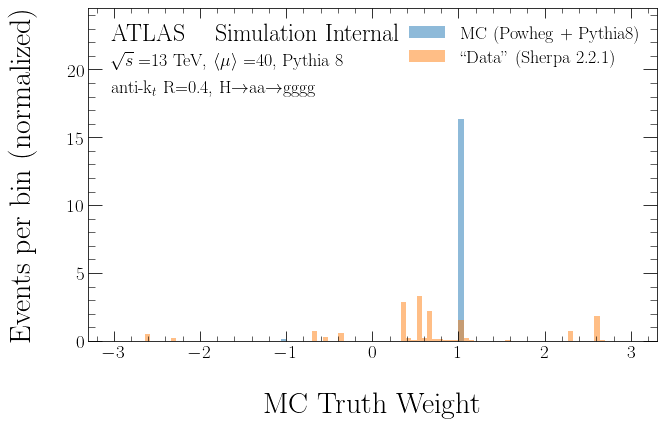

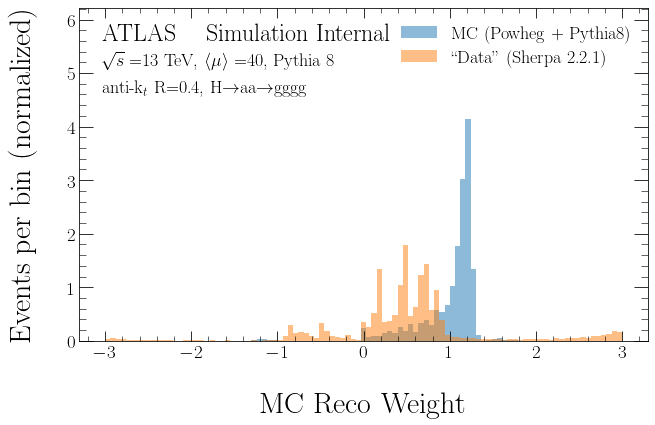

In [147]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc_truth_weights,
                              bins=bins,
                              label=r'MC (Powheg + Pythia8)',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth_weights,
                               bins=bins,
                               label=r'``Data" (Sherpa 2.2.1)',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc_reco_weights,
                             bins=bins,
                             label=r'MC (Powheg + Pythia8)',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data_reco_weights,
                              bins=bins,
                              label=r'``Data" (Sherpa 2.2.1)',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms for comparison

In [148]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [149]:
IBU_hists = uproot.open('/clusterfs/ml4hep/adisurtya/ATLASOmniFold/unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [150]:
labels_and_bins = zip(file_labels, plot_labels, bins)

ibu_hists = []

for file_label, plot_label, plot_bins in labels_and_bins:
    ibu_hists += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

In [151]:
ibu_hists_df = pd.DataFrame(ibu_hists)

In [152]:
ibu_hists_df

,file_label,plot_label,bins
0,Ntracks_trackj1,Leading track jet $n_{\textrm{ch}}$,"[1.0, 5.0, 7.0, 10.0, 13.0, 16.0, 20.0, 30.0, ..."
1,Ntracks_trackj2,Subleading track jet $n_{\textrm{ch}}$,"[1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 11.0, 15.0, 20...."
2,m_trackj1,Leading track jet $m$ [GeV],"[0.0, 10.0, 20.0, 30.0, 40.0, 80.0]"
3,m_trackj2,Subleading track jet $m$ [GeV],"[0.0, 2.5, 5.0, 10.0, 20.0, 70.0]"
4,pT_trackj1,Leading track jet $p_T$ [GeV],"[0.0, 50.0, 100.0, 150.0, 200.0, 300.0, 1000.0]"
5,pT_trackj2,Subleading track jet $p_T$ [GeV],"[0.0, 25.0, 50.0, 100.0, 700.0]"
6,y_trackj1,Leading track jet $y$,"[-2.5, -2.25, -2.0, -1.75, -1.5, -1.25, -1.0, ..."
7,y_trackj2,Subleading track jet $y$,"[-2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, ..."
8,phi_trackj1,Leading track jet $\phi$,"[-3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1...."
9,phi_trackj2,Subleading track jet $\phi$,"[-3.2, -2.8, -2.4, -2.0, -1.6, -1.2, -0.8, -0...."


### Unifold

In [153]:
K.clear_session()

In [154]:
unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_truth_weights)))

In [155]:
unifold_weights.shape # (n_variables, n_events)

(24, 416725)

In [156]:
i = 0 # index of variable of interest (num_tracks for leading jet)
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0+'-UniFold-'+file_label
print("Saving as {}.".format(save_label))

Saving as ./plots/UniFold/Ntracks_trackj1/iteration_test_extreme_weights-UniFold-Ntracks_trackj1.


Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [157]:
dummyval = -99
mc_truth = mc[(mc.pass190 | mc.truth_pass190)]['truth_' + file_label]
mc_truth[mc.truth_pass190 == False] = dummyval
mc_reco = mc[(mc.pass190 | mc.truth_pass190)][file_label]
mc_reco[mc.pass190 == False] = dummyval

data_truth = data[data['truth_pass190']]['truth_' + file_label]
data_reco = data[data['pass190']][file_label]

Plot this observable in MC & "data" before unfolding:

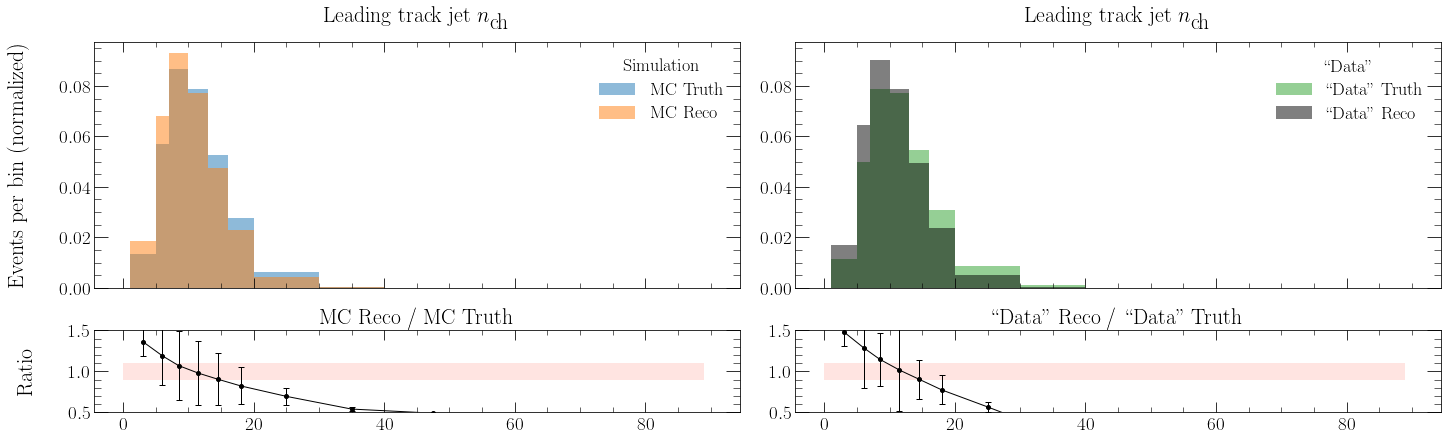

In [158]:
plot_distributions(
    sim_truth=mc_truth,
    sim_reco=mc_reco,
    sim_truth_weights_MC=mc_truth_weights,
    sim_reco_weights_MC=mc_reco_weights,
    data_truth=data_truth,
    data_reco=data_reco,
    data_truth_weights_MC=data_truth_weights,
    data_reco_weights_MC=data_reco_weights,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [159]:
# z-score standardization of data

mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc_truth), 
                                                   np.array(mc_reco),
                                                   np.array(data_reco))

In [160]:
weights, _ = unifold(iterations=10,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc_truth_weights,
                     sim_reco_weights_MC=mc_reco_weights,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights,
                     dummyval=dummyval,
                     verbose=0,
                    )

  0%|          | 0/10 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)
100%|██████████| 10/10 [03:53<00:00, 23.34s/it]


In [161]:
unifold_weights[i] = best_1D_reweighting(
    test=mc_reco,
    test_weights=np.array(mc_reco_weights) * weights[:,1],
    target=data_reco,
    target_weights=data_reco_weights,
    bins=bins)

(array([2.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 8.00000e+00, 1.70000e+01, 1.90000e+01, 6.80000e+01,
        9.01000e+02, 1.37300e+03, 6.03000e+02, 3.16000e+02, 2.21000e+02,
        1.78000e+02, 1.34000e+02, 1.15000e+02, 9.60000e+01, 4.60000e+01,
        3.40000e+01, 8.65100e+03, 4.65300e+03, 8.34600e+03, 9.81500e+03,
        1.12370e+04, 1.37340e+04, 1.77970e+04, 2.50160e+04, 4.21700e+04,
        1.08467e+05, 1.26066e+05, 2.90990e+04, 2.96500e+03, 2.11600e+03,
        1.13300e+03, 5.47000e+02, 1.24000e+02, 1.21000e+02, 8.50000e+01,
        1.24000e+02, 1.34000e+02, 8.60000e+01, 8.50000e+01, 1.20000e+01,
        4.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([-2.503169  , -2.38510805, -2.2670471 , -2.14898615, -2.0309252 ,
        -1.91286425, -1.7948033 , -1.67674235, -1.5586814 , -1.44062044,
        -1.32255949, -1.20449854, -1.08643759, -0.96837664, -0.85031569,
        -0.73225474, -0.61419379, -0.49613284, -0

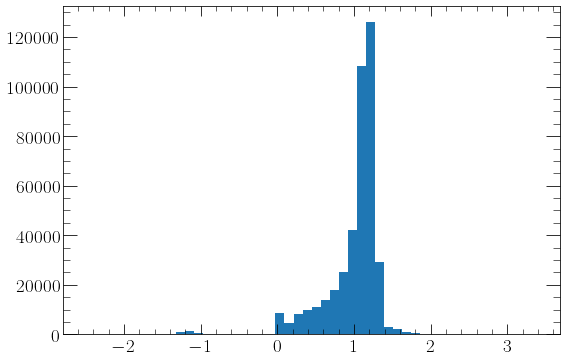

In [162]:
plt.hist(unifold_weights[i], bins=50)

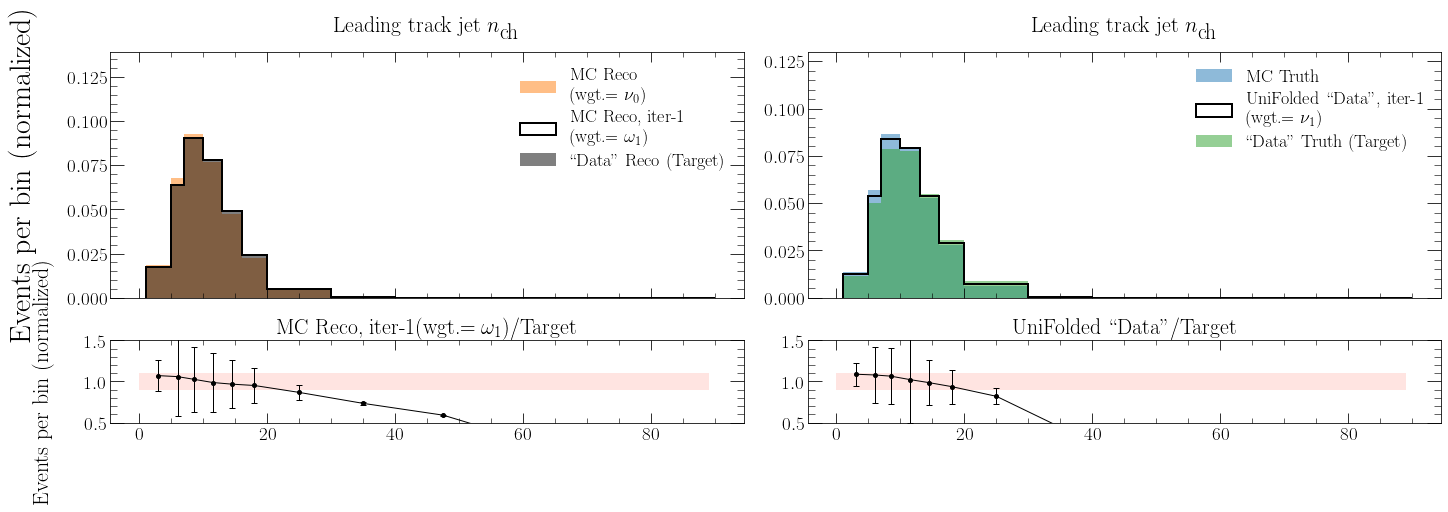

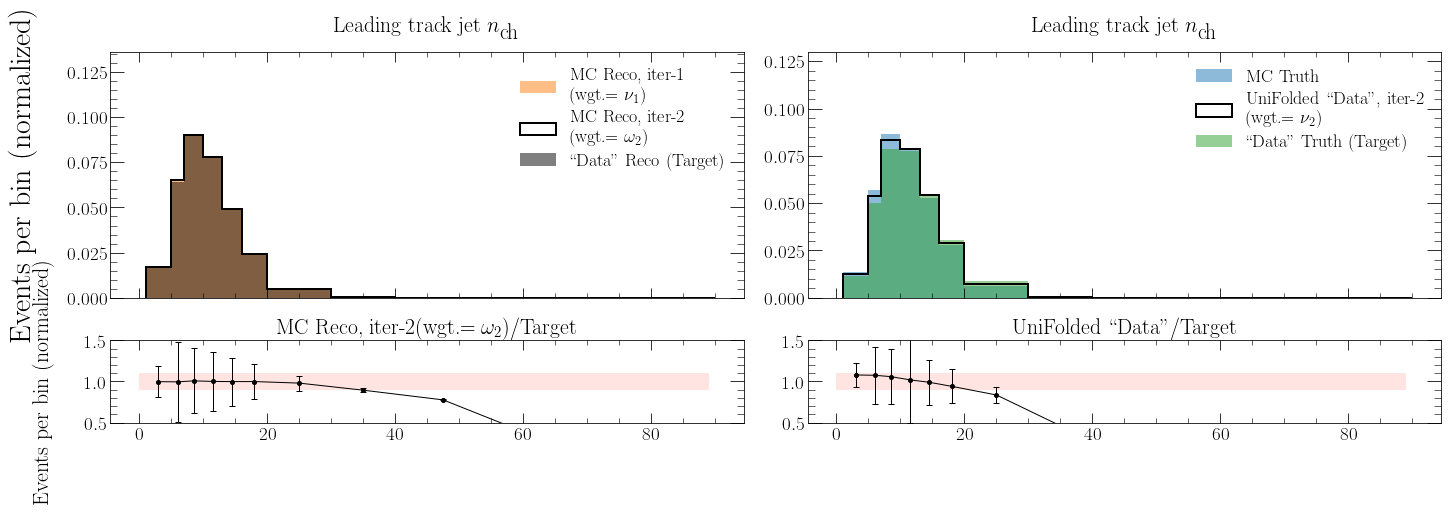

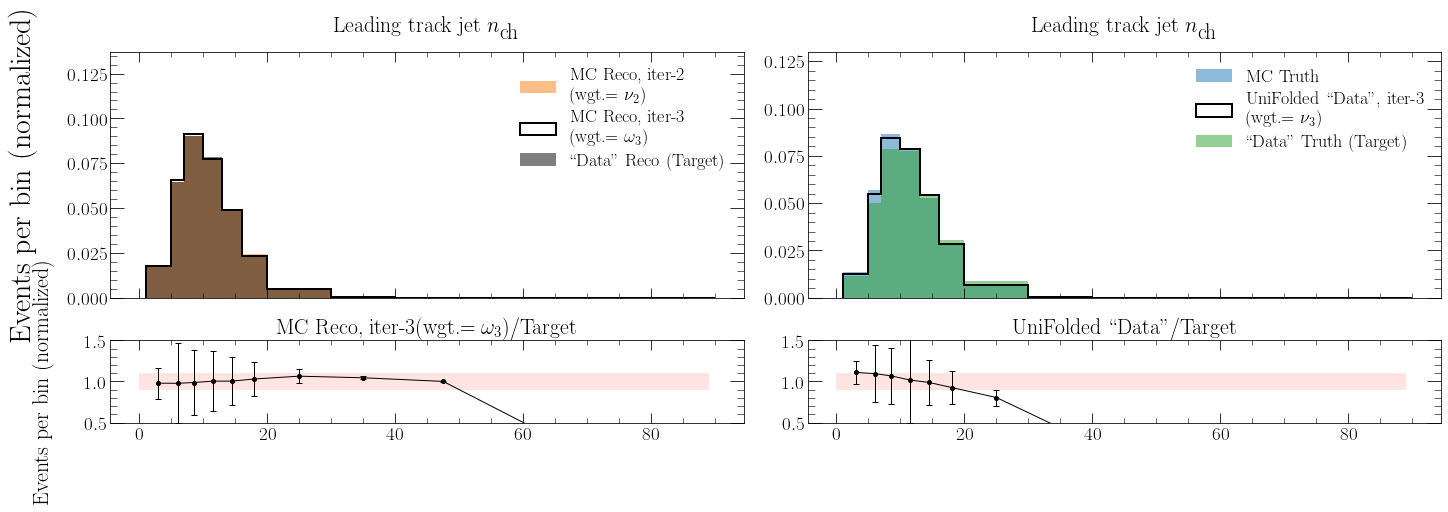

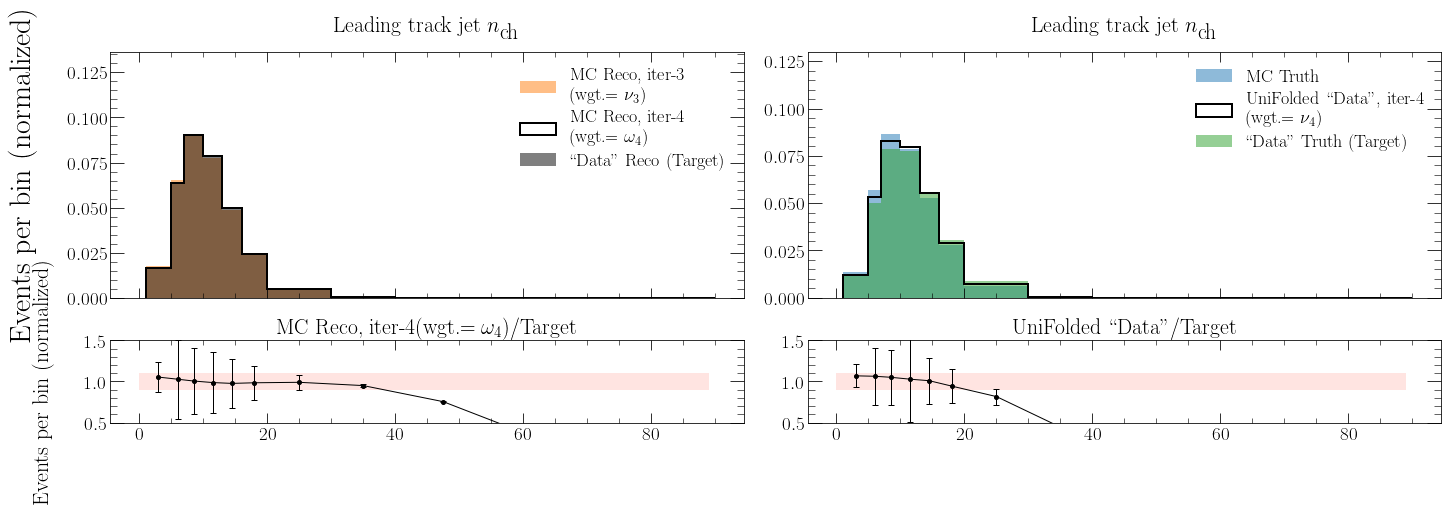

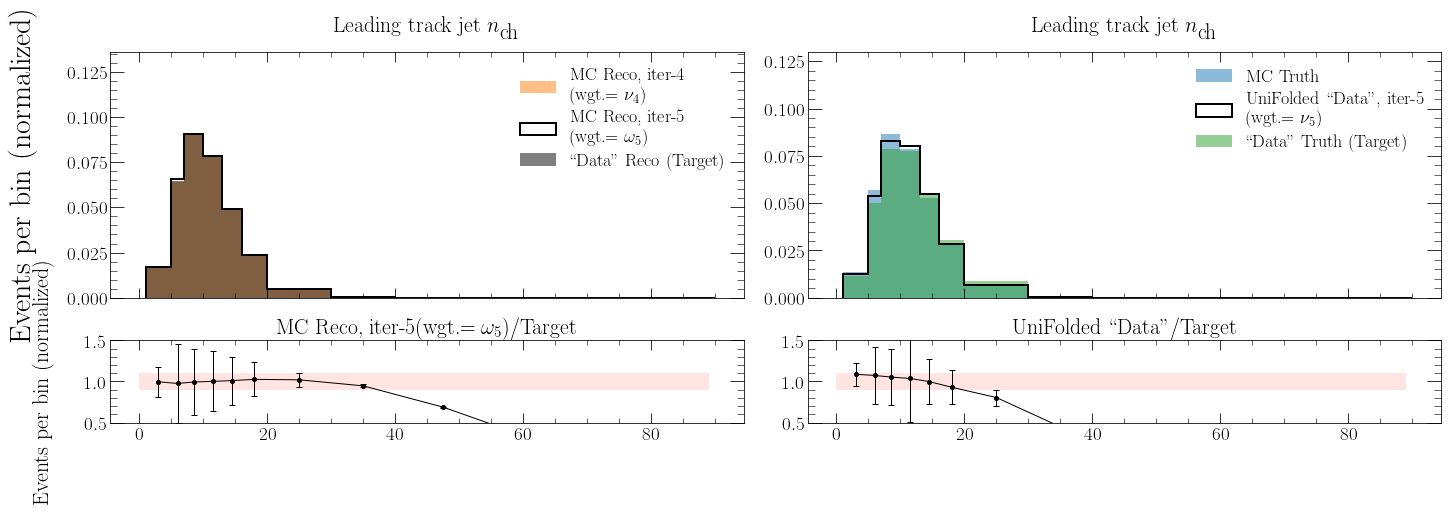

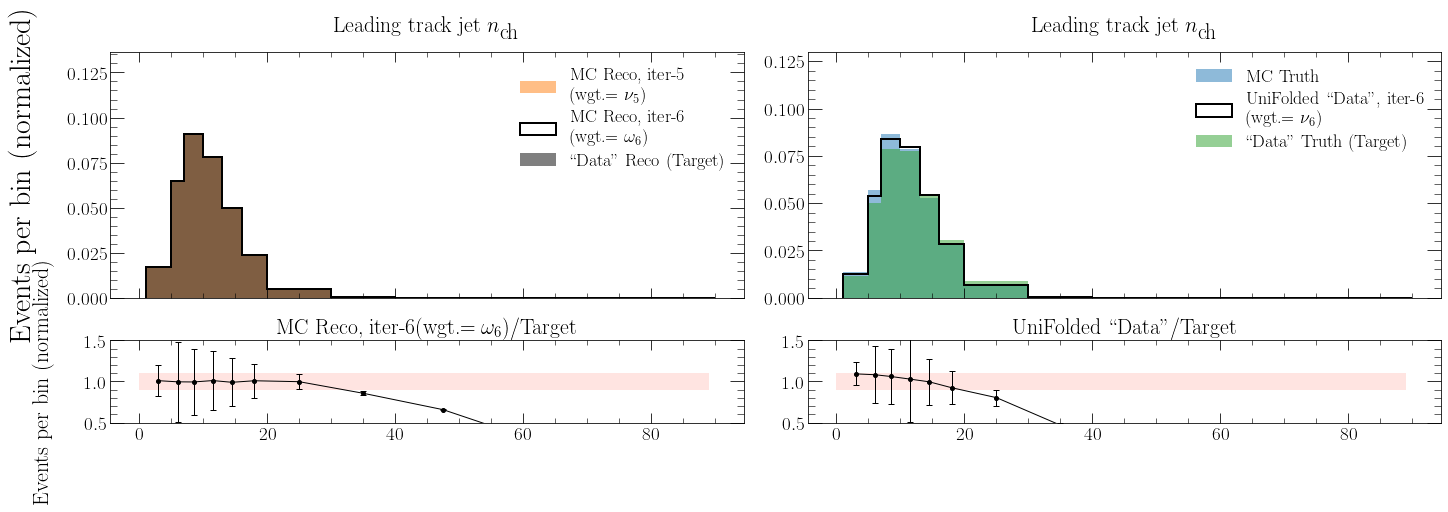

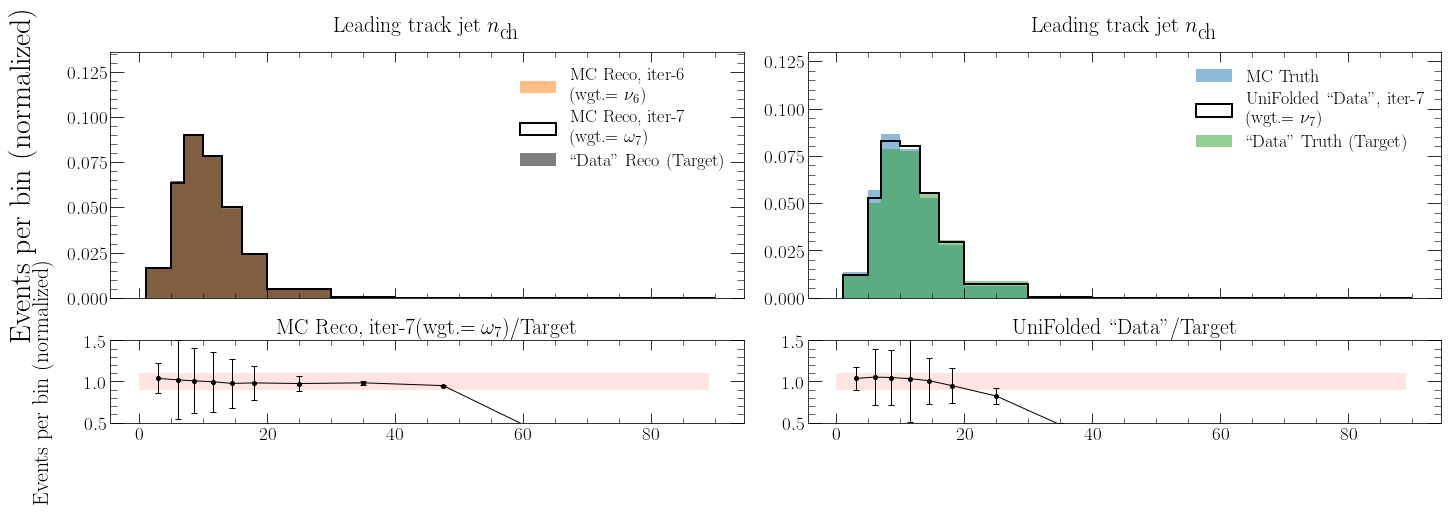

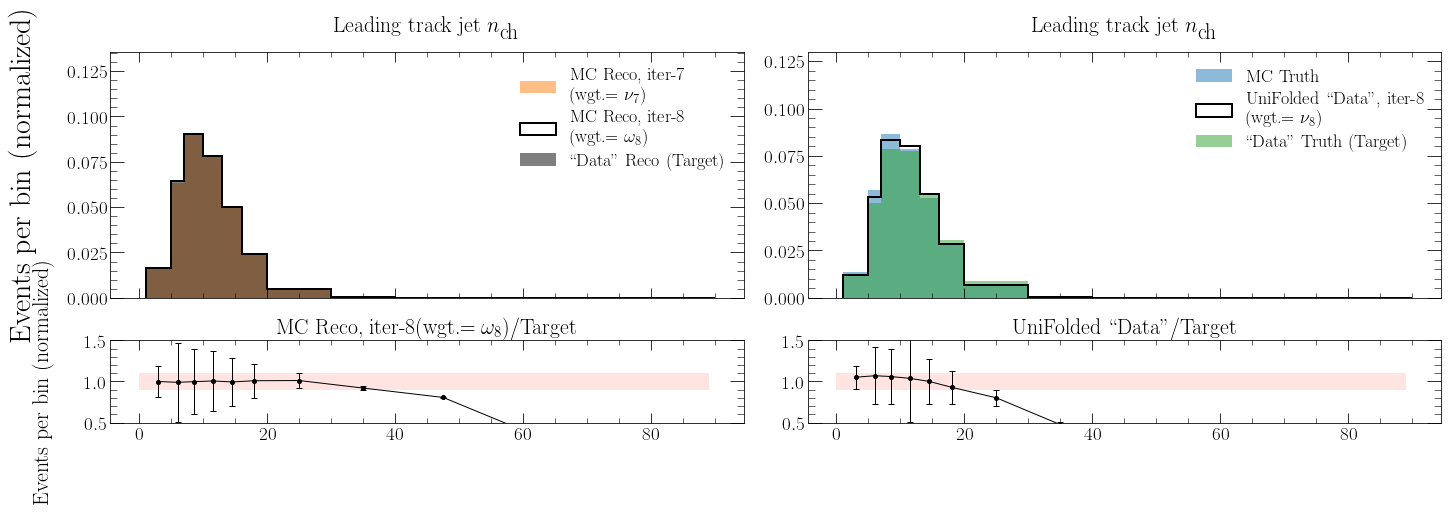

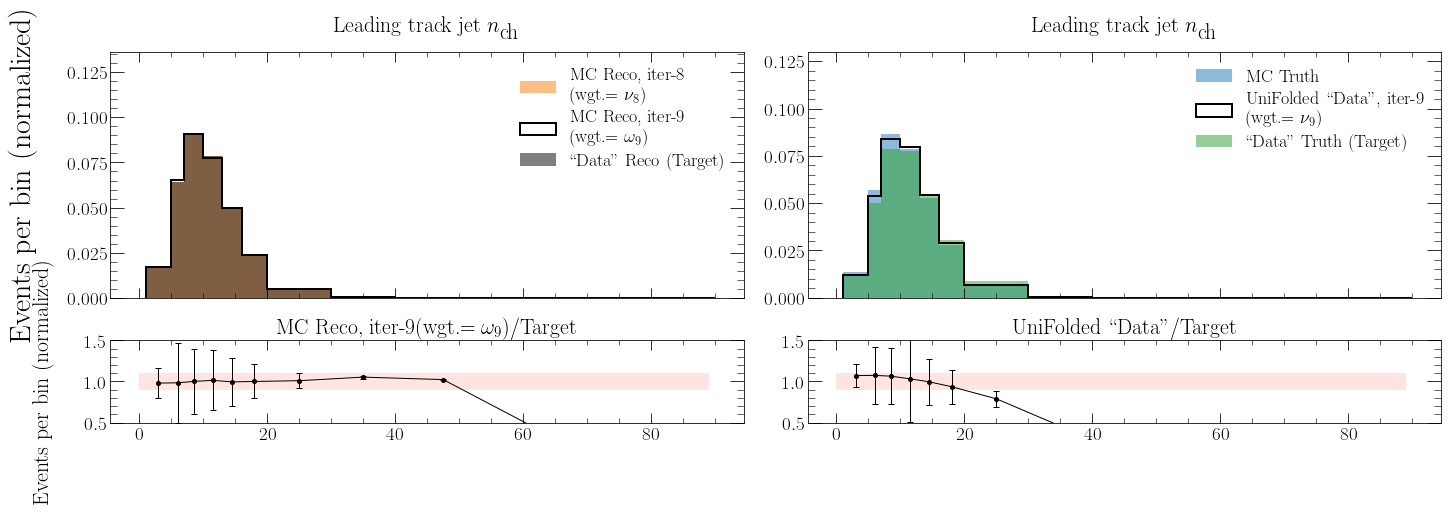

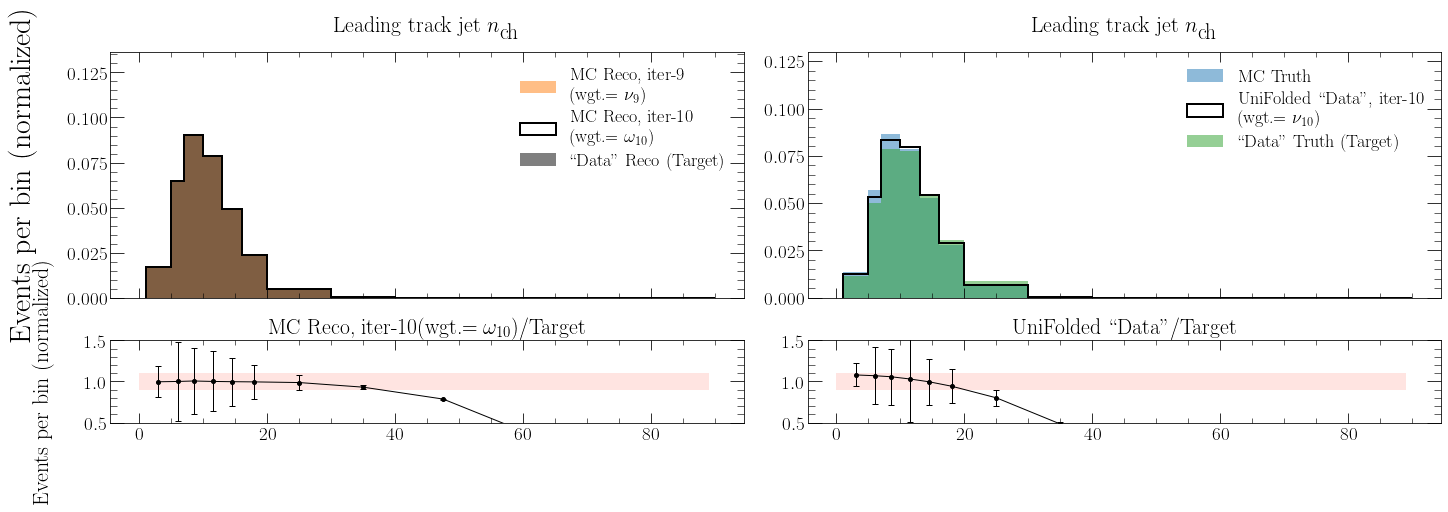

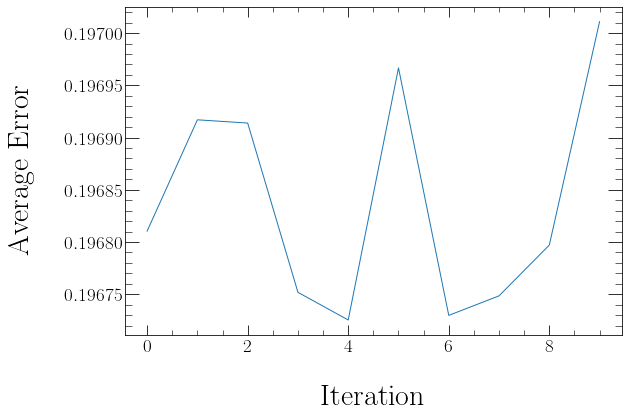

In [163]:
plot_results(sim_truth=mc_truth,
             sim_reco=mc_reco,
             sim_truth_weights_MC=mc_truth_weights,
             sim_reco_weights_MC=mc_reco_weights,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights,
             data_reco_weights_MC=data_reco_weights,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )